In [1]:
import numpy as np

In [2]:
def extractPoseHand(npy):
    np_matrix=npy.reshape(-1,1629)
    # arr = []
    # print(np_matrix.shape)
    pose  = np_matrix[: ,0:99]
    hands  = np_matrix[: ,1503:1629]
    
 
    arr = np.concatenate((pose, hands), axis=1)


      
    return arr

In [3]:
import random
import os
import numpy as np

crossValidationDataPaths=['NORMALIZED/NumericalData/ML/Training/RightHand','NORMALIZED/NumericalData/ML/Training/LeftHand']
testPaths=['NORMALIZED/NumericalData/ML/Test/RightHand','NORMALIZED/NumericalData/ML/Test/LeftHand']



ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)



x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    # npy_matrix=npy.reshape(-1,1629)
   
    npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    

test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    # npy_matrix=npy.reshape(-1,1629)

    npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [4]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 64
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
input_shape = (MAX_FRMAE,225) # pose hands



log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)

2024-01-01 10:00:19.787519: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-01 10:00:19.904174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 10:00:19.904211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 10:00:19.923942: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 10:00:19.965766: I tensorflow/core/platform/cpu_feature_guar

[38, 36, 12, 12, 5, 8, 24, 45, 50, 44, 43, 43, 12, 48, 26, 42, 58, 53, 50, 41, 55, 40, 29, 9, 36, 0, 51, 20, 36, 2, 32, 14, 22, 23, 31, 27, 4, 54, 22, 25, 18, 43, 54, 51, 49, 11, 18, 44, 53, 2, 26, 14, 37, 21, 52, 11, 24, 52, 53, 19, 31, 17, 48, 37, 54, 23, 53, 14, 35, 52, 41, 59, 25, 31, 14, 51, 14, 27, 57, 1, 32, 28, 8, 33, 42, 52, 58, 23, 11, 27, 17, 45, 9, 16, 4, 56, 2, 17, 55, 30, 27, 49, 22, 12, 59, 31, 41, 29, 1, 9, 5, 0, 31, 46, 53, 10, 57, 44, 27, 4, 47, 16, 14, 54, 54, 27, 50, 7, 50, 13, 46, 39, 15, 23, 39, 15, 13, 8, 59, 29, 58, 58, 10, 24, 4, 37, 18, 9, 42, 28, 58, 25, 31, 26, 2, 3, 51, 23, 15, 49, 5, 7, 24, 4, 37, 21, 49, 16, 19, 16, 11, 10, 40, 33, 23, 36, 0, 17, 44, 41, 45, 41, 10, 59, 19, 59, 32, 50, 56, 37, 32, 45, 14, 16, 22, 54, 0, 8, 58, 21, 15, 21, 46, 27, 25, 5, 10, 54, 51, 16, 55, 31, 49, 24, 8, 21, 45, 9, 5, 4, 14, 34, 45, 23, 15, 22, 26, 41, 53, 53, 3, 11, 48, 5, 54, 14, 25, 58, 57, 27, 40, 40, 19, 27, 9, 22, 4, 43, 35, 32, 22, 42, 30, 21, 0, 48, 54, 45, 34, 31

In [5]:

import tensorflow as tf
import gc

# Define and compile the model


num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    # early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size,validation_data=(x_train[test],y_train[test]))

    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
    tf.keras.backend.clear_session()
    del model
    gc.collect()
    


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")


2024-01-01 10:00:24.069359: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-01-01 10:00:24.069384: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2024-01-01 10:00:24.069388: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2024-01-01 10:00:24.069482: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2024-01-01 10:00:24.069492: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2024-01-01 10:00:24.069494: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1704081633.771365  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9752 - accuracy: 0.0512

W0000 00:00:1704081641.023376  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 10s 64ms/step - loss: 3.9752 - accuracy: 0.0512 - val_loss: 3.6726 - val_accuracy: 0.1020
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.4801 - accuracy: 0.1580 - val_loss: 3.1019 - val_accuracy: 0.2699
Epoch 3/200
113/113 [==============================] - 7s 58ms/step - loss: 3.0611 - accuracy: 0.2394 - val_loss: 2.6859 - val_accuracy: 0.4154
Epoch 4/200
113/113 [==============================] - 7s 58ms/step - loss: 2.7456 - accuracy: 0.3094 - val_loss: 2.3500 - val_accuracy: 0.4925
Epoch 5/200
113/113 [==============================] - 7s 58ms/step - loss: 2.5164 - accuracy: 0.3635 - val_loss: 2.0955 - val_accuracy: 0.5585
Epoch 6/200
113/113 [==============================] - 7s 58ms/step - loss: 2.3012 - accuracy: 0.4042 - val_loss: 1.8974 - val_accuracy: 0.6007
Epoch 7/200
113/113 [==============================] - 7s 58ms/step - loss: 2.1260 - accuracy: 0.4516 - val_loss: 1.6905 - val_accuracy: 0.6580
Epo

W0000 00:00:1704083533.376788  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 32ms/step
Validation Accuracy Fold 1: 0.9738805970149254
40/40 [==============================] - 1s 33ms/step
Test - Accuracy: 0.6363636363636364
---------------fold 2 -----------
Epoch 1/200


W0000 00:00:1704083543.149012  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9255 - accuracy: 0.0612

W0000 00:00:1704083559.731253  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 21s 148ms/step - loss: 3.9255 - accuracy: 0.0612 - val_loss: 3.6226 - val_accuracy: 0.1233
Epoch 2/200
113/113 [==============================] - 15s 134ms/step - loss: 3.4012 - accuracy: 0.1580 - val_loss: 3.0623 - val_accuracy: 0.3014
Epoch 3/200
113/113 [==============================] - 15s 132ms/step - loss: 2.9981 - accuracy: 0.2515 - val_loss: 2.6835 - val_accuracy: 0.3873
Epoch 4/200
113/113 [==============================] - 15s 135ms/step - loss: 2.6991 - accuracy: 0.3170 - val_loss: 2.3839 - val_accuracy: 0.4857
Epoch 5/200
113/113 [==============================] - 15s 131ms/step - loss: 2.4558 - accuracy: 0.3791 - val_loss: 2.1620 - val_accuracy: 0.5367
Epoch 6/200
113/113 [==============================] - 15s 133ms/step - loss: 2.2548 - accuracy: 0.4287 - val_loss: 1.9372 - val_accuracy: 0.5629
Epoch 7/200
113/113 [==============================] - 15s 135ms/step - loss: 2.1142 - accuracy: 0.4517 - val_loss: 1.8143 - val_accurac

W0000 00:00:1704086561.892297  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 38ms/step
Validation Accuracy Fold 2: 0.9688667496886675
40/40 [==============================] - 2s 37ms/step
Test - Accuracy: 0.6308777429467085
---------------fold 3 -----------
Epoch 1/200


W0000 00:00:1704086571.596454  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9316 - accuracy: 0.0588

W0000 00:00:1704086588.043893  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 22s 149ms/step - loss: 3.9316 - accuracy: 0.0588 - val_loss: 3.6121 - val_accuracy: 0.1183
Epoch 2/200
113/113 [==============================] - 16s 141ms/step - loss: 3.4348 - accuracy: 0.1615 - val_loss: 3.1376 - val_accuracy: 0.2615
Epoch 3/200
113/113 [==============================] - 15s 136ms/step - loss: 3.0489 - accuracy: 0.2479 - val_loss: 2.7949 - val_accuracy: 0.3350
Epoch 4/200
113/113 [==============================] - 15s 133ms/step - loss: 2.7700 - accuracy: 0.3146 - val_loss: 2.4749 - val_accuracy: 0.4296
Epoch 5/200
113/113 [==============================] - 16s 140ms/step - loss: 2.5575 - accuracy: 0.3621 - val_loss: 2.2535 - val_accuracy: 0.4944
Epoch 6/200
113/113 [==============================] - 15s 134ms/step - loss: 2.3796 - accuracy: 0.3989 - val_loss: 2.0645 - val_accuracy: 0.5666
Epoch 7/200
113/113 [==============================] - 15s 134ms/step - loss: 2.2157 - accuracy: 0.4379 - val_loss: 1.9017 - val_accurac

W0000 00:00:1704089577.839558  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 40ms/step
Validation Accuracy Fold 3: 0.9763387297633873
40/40 [==============================] - 1s 34ms/step
Test - Accuracy: 0.5744514106583072
---------------fold 4 -----------
Epoch 1/200


W0000 00:00:1704089588.424843  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9473 - accuracy: 0.0610

W0000 00:00:1704089604.283099  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 20s 143ms/step - loss: 3.9473 - accuracy: 0.0610 - val_loss: 3.6898 - val_accuracy: 0.1582
Epoch 2/200
113/113 [==============================] - 15s 136ms/step - loss: 3.4460 - accuracy: 0.1579 - val_loss: 3.1361 - val_accuracy: 0.2989
Epoch 3/200
113/113 [==============================] - 14s 126ms/step - loss: 3.0352 - accuracy: 0.2530 - val_loss: 2.6955 - val_accuracy: 0.4035
Epoch 4/200
113/113 [==============================] - 15s 131ms/step - loss: 2.7068 - accuracy: 0.3226 - val_loss: 2.3957 - val_accuracy: 0.4745
Epoch 5/200
113/113 [==============================] - 15s 137ms/step - loss: 2.4916 - accuracy: 0.3662 - val_loss: 2.1722 - val_accuracy: 0.5367
Epoch 6/200
113/113 [==============================] - 15s 134ms/step - loss: 2.2980 - accuracy: 0.4235 - val_loss: 1.9416 - val_accuracy: 0.5766
Epoch 7/200
113/113 [==============================] - 15s 134ms/step - loss: 2.1325 - accuracy: 0.4589 - val_loss: 1.8326 - val_accurac

W0000 00:00:1704091714.968260  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 4: 0.9825653798256538
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6105015673981191
---------------fold 5 -----------
Epoch 1/200


W0000 00:00:1704091719.394481  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9056 - accuracy: 0.0589

W0000 00:00:1704091726.530061  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.9056 - accuracy: 0.0589 - val_loss: 3.4907 - val_accuracy: 0.1731
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.3166 - accuracy: 0.1843 - val_loss: 2.8895 - val_accuracy: 0.3524
Epoch 3/200
113/113 [==============================] - 7s 59ms/step - loss: 2.8948 - accuracy: 0.2741 - val_loss: 2.4991 - val_accuracy: 0.4670
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.5732 - accuracy: 0.3462 - val_loss: 2.1693 - val_accuracy: 0.5405
Epoch 5/200
113/113 [==============================] - 7s 59ms/step - loss: 2.3334 - accuracy: 0.3982 - val_loss: 1.9461 - val_accuracy: 0.5890
Epoch 6/200
113/113 [==============================] - 7s 59ms/step - loss: 2.1466 - accuracy: 0.4487 - val_loss: 1.7763 - val_accuracy: 0.6252
Epoch 7/200
113/113 [==============================] - 7s 59ms/step - loss: 1.9860 - accuracy: 0.4801 - val_loss: 1.6044 - val_accuracy: 0.6837
Epoc

W0000 00:00:1704093056.361137  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 5: 0.975093399750934
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5995297805642633
---------------fold 6 -----------
Epoch 1/200


W0000 00:00:1704093060.787866  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9587 - accuracy: 0.0530

W0000 00:00:1704093068.004619  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 9s 64ms/step - loss: 3.9587 - accuracy: 0.0530 - val_loss: 3.7187 - val_accuracy: 0.1494
Epoch 2/200
113/113 [==============================] - 7s 59ms/step - loss: 3.5299 - accuracy: 0.1520 - val_loss: 3.2389 - val_accuracy: 0.2130
Epoch 3/200
113/113 [==============================] - 7s 60ms/step - loss: 3.1642 - accuracy: 0.2234 - val_loss: 2.8975 - val_accuracy: 0.3126
Epoch 4/200
113/113 [==============================] - 7s 59ms/step - loss: 2.8925 - accuracy: 0.2849 - val_loss: 2.5791 - val_accuracy: 0.4134
Epoch 5/200
113/113 [==============================] - 7s 58ms/step - loss: 2.6617 - accuracy: 0.3304 - val_loss: 2.3670 - val_accuracy: 0.4558
Epoch 6/200
113/113 [==============================] - 7s 58ms/step - loss: 2.4680 - accuracy: 0.3722 - val_loss: 2.1346 - val_accuracy: 0.5268
Epoch 7/200
113/113 [==============================] - 7s 58ms/step - loss: 2.3109 - accuracy: 0.4091 - val_loss: 1.9804 - val_accuracy: 0.5679
Epoc

W0000 00:00:1704095988.794922  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 42ms/step
Validation Accuracy Fold 6: 0.9763387297633873
40/40 [==============================] - 2s 39ms/step
Test - Accuracy: 0.6026645768025078
---------------fold 7 -----------
Epoch 1/200


W0000 00:00:1704095999.060140  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9404 - accuracy: 0.0563

W0000 00:00:1704096016.053950  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 22s 153ms/step - loss: 3.9404 - accuracy: 0.0563 - val_loss: 3.6501 - val_accuracy: 0.1395
Epoch 2/200
113/113 [==============================] - 16s 137ms/step - loss: 3.4700 - accuracy: 0.1526 - val_loss: 3.1460 - val_accuracy: 0.2540
Epoch 3/200
113/113 [==============================] - 15s 130ms/step - loss: 3.1050 - accuracy: 0.2322 - val_loss: 2.8307 - val_accuracy: 0.3375
Epoch 4/200
113/113 [==============================] - 14s 127ms/step - loss: 2.8176 - accuracy: 0.2966 - val_loss: 2.5623 - val_accuracy: 0.4421
Epoch 5/200
113/113 [==============================] - 15s 136ms/step - loss: 2.5754 - accuracy: 0.3442 - val_loss: 2.2844 - val_accuracy: 0.4757
Epoch 6/200
113/113 [==============================] - 16s 140ms/step - loss: 2.3947 - accuracy: 0.3864 - val_loss: 2.1086 - val_accuracy: 0.5255
Epoch 7/200
113/113 [==============================] - 15s 135ms/step - loss: 2.2323 - accuracy: 0.4196 - val_loss: 1.9731 - val_accurac

W0000 00:00:1704099053.063056  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 36ms/step
Validation Accuracy Fold 7: 0.9701120797011208
40/40 [==============================] - 1s 34ms/step
Test - Accuracy: 0.6536050156739812
---------------fold 8 -----------
Epoch 1/200


W0000 00:00:1704099063.306757  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9348 - accuracy: 0.0570

W0000 00:00:1704099080.384589  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 22s 155ms/step - loss: 3.9348 - accuracy: 0.0570 - val_loss: 3.6455 - val_accuracy: 0.1370
Epoch 2/200
113/113 [==============================] - 15s 132ms/step - loss: 3.3747 - accuracy: 0.1700 - val_loss: 3.0434 - val_accuracy: 0.2914
Epoch 3/200
113/113 [==============================] - 15s 136ms/step - loss: 2.9672 - accuracy: 0.2521 - val_loss: 2.6625 - val_accuracy: 0.3773
Epoch 4/200
113/113 [==============================] - 15s 131ms/step - loss: 2.6528 - accuracy: 0.3260 - val_loss: 2.3166 - val_accuracy: 0.4857
Epoch 5/200
113/113 [==============================] - 15s 132ms/step - loss: 2.4068 - accuracy: 0.3762 - val_loss: 2.0624 - val_accuracy: 0.5629
Epoch 6/200
113/113 [==============================] - 16s 137ms/step - loss: 2.1999 - accuracy: 0.4189 - val_loss: 1.8163 - val_accuracy: 0.5853
Epoch 7/200
113/113 [==============================] - 15s 131ms/step - loss: 2.0369 - accuracy: 0.4689 - val_loss: 1.6635 - val_accurac

W0000 00:00:1704102141.151921  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 38ms/step
Validation Accuracy Fold 8: 0.9713574097135741
40/40 [==============================] - 1s 36ms/step
Test - Accuracy: 0.6018808777429467
---------------fold 9 -----------
Epoch 1/200


W0000 00:00:1704102153.267956  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.9276 - accuracy: 0.0603

W0000 00:00:1704102170.686251  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 23s 155ms/step - loss: 3.9276 - accuracy: 0.0603 - val_loss: 3.5844 - val_accuracy: 0.1445
Epoch 2/200
113/113 [==============================] - 16s 140ms/step - loss: 3.3691 - accuracy: 0.1657 - val_loss: 3.0037 - val_accuracy: 0.2877
Epoch 3/200
113/113 [==============================] - 15s 134ms/step - loss: 2.9728 - accuracy: 0.2579 - val_loss: 2.6352 - val_accuracy: 0.4122
Epoch 4/200
113/113 [==============================] - 16s 138ms/step - loss: 2.6633 - accuracy: 0.3251 - val_loss: 2.3745 - val_accuracy: 0.4894
Epoch 5/200
113/113 [==============================] - 16s 142ms/step - loss: 2.4452 - accuracy: 0.3712 - val_loss: 2.1332 - val_accuracy: 0.5592
Epoch 6/200
113/113 [==============================] - 15s 136ms/step - loss: 2.2389 - accuracy: 0.4281 - val_loss: 1.8975 - val_accuracy: 0.5866
Epoch 7/200
113/113 [==============================] - 15s 135ms/step - loss: 2.0819 - accuracy: 0.4654 - val_loss: 1.7863 - val_accurac

W0000 00:00:1704105222.394845  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 45ms/step
Validation Accuracy Fold 9: 0.9651307596513076
40/40 [==============================] - 2s 40ms/step
Test - Accuracy: 0.6183385579937304
---------------fold 10 -----------
Epoch 1/200


W0000 00:00:1704105234.823323  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - ETA: 0s - loss: 3.8954 - accuracy: 0.0638

W0000 00:00:1704105250.699609  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


113/113 [==============================] - 21s 143ms/step - loss: 3.8954 - accuracy: 0.0638 - val_loss: 3.5135 - val_accuracy: 0.1706
Epoch 2/200
113/113 [==============================] - 15s 133ms/step - loss: 3.3571 - accuracy: 0.1709 - val_loss: 3.0459 - val_accuracy: 0.2553
Epoch 3/200
113/113 [==============================] - 15s 131ms/step - loss: 2.9369 - accuracy: 0.2566 - val_loss: 2.5887 - val_accuracy: 0.4209
Epoch 4/200
113/113 [==============================] - 16s 139ms/step - loss: 2.5984 - accuracy: 0.3365 - val_loss: 2.2861 - val_accuracy: 0.5143
Epoch 5/200
113/113 [==============================] - 16s 141ms/step - loss: 2.3613 - accuracy: 0.3950 - val_loss: 2.0525 - val_accuracy: 0.5741
Epoch 6/200
113/113 [==============================] - 15s 137ms/step - loss: 2.1770 - accuracy: 0.4442 - val_loss: 1.8438 - val_accuracy: 0.6189
Epoch 7/200
113/113 [==============================] - 15s 134ms/step - loss: 2.0054 - accuracy: 0.4752 - val_loss: 1.6869 - val_accurac

W0000 00:00:1704108314.897670  554610 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 2s 41ms/step
Validation Accuracy Fold 10: 0.9713574097135741
40/40 [==============================] - 1s 34ms/step
Test - Accuracy: 0.6253918495297806
Average  cross validation accuracy: {average_accuracy}
Average test accuracy: {average_accuracy}


In [6]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

[0.6363636363636364, 0.6308777429467085, 0.5744514106583072, 0.6105015673981191, 0.5995297805642633, 0.6026645768025078, 0.6536050156739812, 0.6018808777429467, 0.6183385579937304, 0.6253918495297806]
0.6153605015673982
[0.9738805970149254, 0.9688667496886675, 0.9763387297633873, 0.9825653798256538, 0.975093399750934, 0.9763387297633873, 0.9701120797011208, 0.9713574097135741, 0.9651307596513076, 0.9713574097135741]
0.9731041244586531


test accuracies:  [0.6363636363636364, 0.6308777429467085, 0.5744514106583072, 0.6105015673981191, 0.5995297805642633, 0.6026645768025078, 0.6536050156739812, 0.6018808777429467, 0.6183385579937304, 0.6253918495297806] 6
validation accuracies:  [0.9738805970149254, 0.9688667496886675, 0.9763387297633873, 0.9825653798256538, 0.975093399750934, 0.9763387297633873, 0.9701120797011208, 0.9713574097135741, 0.9651307596513076, 0.9713574097135741]
60


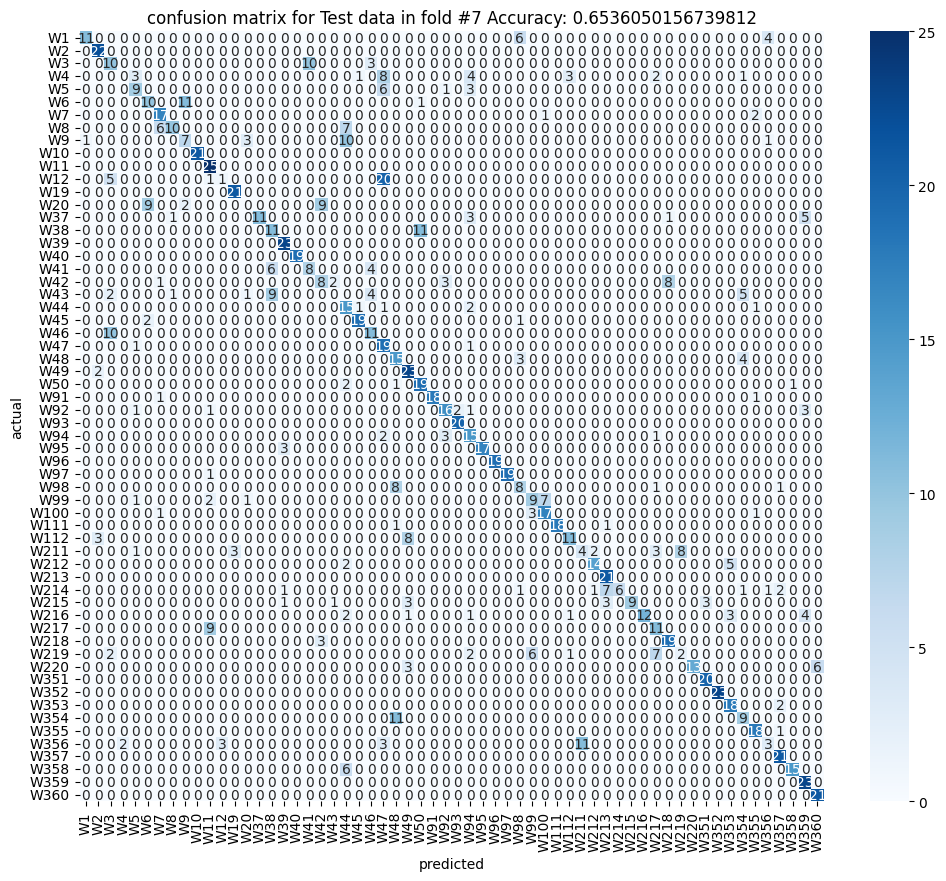

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, bestTest-1)
print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()
